## Train the soccerWorld Environment with Q-Learning

### SoccerWorld Env

The SoccerWorld Env is a simple ball to goal environment. Where the ball going to opponent is considered reward of -1 and to the goal reward of +1

The observation is an image obtained by a camera on top of the soccerWorld.

The Action space is continous : <br>
    - X direction force <br>
    - Z direction force <br>

Goal is to maximise reward - We use DQN for the same




### The Q-Learning Algorithm


In this Notebook, we will implement a very simple Q-Learning algorithm. We will use [pytorch](https://pytorch.org/) to do so.

Below is the code to create the neural network we will use in the Notebook.

<h3>Conv Calculations</h3>
<img src="convCalc.png" alt="convCalculations">

### Eh? But why do we need this ?  <br >Because right after conv layers we have regular neural layers and we got to tell those layers what inputs they are gonna get!

#### conv2d Initialization:
torch.nn.Conv2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, dilation: Union[T, Tuple[T, T]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')

<h3> ConvTransposeCalculations</h3>
<img src="convTranspCalc.png" alt="convTransposeCalculations">

<br>
<br>
H_out =(H_in − 1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1 <br>
W_out =(W_in − 1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1)+output_padding[1]+1

#### convTranspose2D Initialization:
torch.nn.ConvTranspose2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, output_padding: Union[T, Tuple[T, T]] = 0, groups: int = 1, bias: bool = True, dilation: int = 1, padding_mode: str = 'zeros')

In [1]:
import torch
from typing import Tuple
from math import floor


class VisualQNetwork(torch.nn.Module):
  def __init__(
    self,
    input_shape: Tuple[int, int, int], 
    encoding_size: int, 
    output_size: int
  ):
    """
    Define Architecture:
    Input: Env snapshot
    Output: Actions 2 of them
    """
    super(VisualQNetwork, self).__init__()
    #input data characterstics
    height = input_shape[0]
    width = input_shape[1]
    initial_channels = input_shape[2]
    
    #ConvCalc
    conv_1_hw = self.conv_output_shape((height, width), 8, 4)
    conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
    self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32 # we use this as the input to over first FC layer
    
    #Conv Layers begin
    #we are using Kernel size of 8, stride of 4, 16 represents number of channels out of this layer. 
    #Here, 16 represents we are using 16 -> 8x8x3 filters -> output would be of 16 channel
    self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
    #Here, 32 represents we are using 32 -> 4x4x16 filters -> output would be of 32 channel
    self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
    #Conv layers end
    
    #Linear Layers begin
    self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)
    self.dense2 = torch.nn.Linear(encoding_size, output_size)
    #Linear Layers end
    
  def forward(self, visual_obs: torch.tensor): #convert the input np.array to tensor
    #visual_obs is a torch.Size([1, 100, 100, 3])
    visual_obs = visual_obs.permute(0, 3, 1, 2) #0 represent nsmaples= 1; 3 represent channels = 3, 1 represent height= 100, 2 represent width= 100
    # we are needing a input of shape 1 3 100 100 as nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width.
    conv_1 = torch.relu(self.conv1(visual_obs))
    conv_2 = torch.relu(self.conv2(conv_1))
    hidden = self.dense1(conv_2.reshape([-1, self.final_flat])) #reshapes the conv2 to 1 X final_flat; 1 represent 1 datapoint to Linear; It's like m;
    '''
    Example:
    m = torch.nn.Linear(20, 30) -> input features X output features
    input = torch.randn(128, 20)
    print("input is: ",input,"\n\n\n")
    print("input size: ",input.shape,"\n\n\n") 128 X 20
    output = m(input)
    print(output.size()) -> 12 X 30

    '''
    hidden = torch.relu(hidden)
    hidden = self.dense2(hidden)
    return hidden #tensor of 2 q values corresponding to 2 actions

  @staticmethod #a static method can be called without creating a class instance as well.
  def conv_output_shape(
    h_w: Tuple[int, int],
    kernel_size: int = 1,
    stride: int = 1,
    pad: int = 0,
    dilation: int = 1,
  ):
    """
    Computes the height and width of the output of a convolution layer using above mentioned formula.
    """
    h = floor(
      ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    w = floor(
      ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    return h, w


In [2]:
net = VisualQNetwork((100, 100, 3), 126, 2)

In [3]:
print(net)

VisualQNetwork(
  (conv1): Conv2d(3, 16, kernel_size=[8, 8], stride=[4, 4])
  (conv2): Conv2d(16, 32, kernel_size=[4, 4], stride=[2, 2])
  (dense1): Linear(in_features=3872, out_features=126, bias=True)
  (dense2): Linear(in_features=126, out_features=2, bias=True)
)


## Experience class to store the data we will use to train the Q-Learning algorithm.

In [4]:
import numpy as np
from typing import NamedTuple, List


class Experience(NamedTuple):
  #declare the datatypes
  obs: np.ndarray #st
  action: np.ndarray #at
  reward: float #rt+1
  done: bool #is the episode over ? will be true when there is a agent in terminal steps!
  next_obs: np.ndarray #st+1

#Global Variable for Trajectory and Buffer!
# A Trajectory is an ordered list of Experiences
Trajectory = List[Experience]

# A Buffer is unordered list of Experiences; this is to break the correlation between experiences; for more general represenation
Buffer = List[Experience]

### Example
Experience(obs=, action=, reward=, done=, next_obs=)

### Trainer class is to collect data from the Environment according to a Policy, and then train the Q-Network with that data and the power of Bellman equations.

### Pseudocode

In [5]:
#Psuedocode:
# 1.Initialize replay memory capacity.
# 2.Initialize the policy network with random weights.
# 3.Clone the policy network, and call it the target network.
# 4.For each episode:
#     1.Initialize the starting state.
#     2.For each time step:
#         1.Select an action.
#             Via exploration or exploitation
#         2.Execute selected action in an emulator.
#         3.Observe reward and next state.
#         4.Store experience in replay memory.
#         5.Sample random batch from replay memory.
#         6.Preprocess states from batch.
#         7.Pass batch of preprocessed states to policy network.
#         8.Calculate loss between output Q-values and target Q-values.
#             Requires a pass to the target network for the next state
#         9.Gradient descent updates weights in the policy network to minimize loss.
#             After  time steps, weights in the target network are updated to the weights in the policy network.


In [8]:
from mlagents_envs.environment import BaseEnv
from typing import Dict
'''
Using Dict
For mappings, we need the types of both keys and values
x: Dict[str, float] = {'field': 2.0}
'''
import random


class Trainer:
  @staticmethod #can be called without a instance of class
  def generate_trajectories(
    env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float
  ):
    """
    Params:
    Input: Unity Environment | Q-Network | Buffer size for Experience Replay | Epsilon for epislon greedy strategy
    Given a Unity Environment and a Q-Network, this method will generate a
    buffer of Experiences obtained by running the Environment with the Policy
    derived from the Q-Network.
    BaseEnv: The Base Env UnityEnvironment gives us, it will be picked if no env is passed!
    q_net: The Q-Network used to collect the data.
    buffer_size: The minimum size of the buffer this method will return.
    epsilon: random sample between 0 and 1 . For exploration/exploitation
    
    Returns: 
    A Tuple containing the created buffer of experiences and the average cumulative reward the Agent obtained.
    """
    # Create an empty Buffer
    buffer: Buffer = [] #list of Experiences

    # Reset the environment
    env.reset()
    # Read and store the Behavior Name of the Environment
    behavior_name = list(env.behavior_specs)[0]
    # Read and store the Behavior Specs of the Environment
    spec = env.behavior_specs[behavior_name]
    #spec has all detials of Env.
    #For example spec.observation_shapes give [(100, 100, 3)] representing one visual observation for our env!
    
    #Creating user Defined dictionary mappings with agentId as key, helpful when there are mutliple agents!
    # Create a Mapping from AgentId to Trajectories - stores trajectory of an agent!
    
    dict_trajectories_from_agent: Dict[int, Trajectory] = {} #int is agentId
        
    # Create a Mapping from AgentId to the last observation st of the Agent
    dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
        
    # Create a Mapping from AgentId to the last action at of the Agent
    dict_last_action_from_agent: Dict[int, np.ndarray] = {}
        
    # Create a Mapping from AgentId to cumulative reward (Only for reporting)
    dict_cumulative_reward_from_agent: Dict[int, float] = {}
        
    # Create a list to store the cumulative rewards obtained so far
    cumulative_rewards: List[float] = []

    while len(buffer) < buffer_size:  # While not enough experiences in the buffer
      # Get the Decision Steps and Terminal Steps of the Agents
      decision_steps, terminal_steps = env.get_steps(behavior_name)

      # For all Agents with a Terminal Step:
      for agent_id_terminated in terminal_steps:
        '''
        Experience:
        obs: np.ndarray
        action: np.ndarray
        reward: float
        done: bool
        next_obs: np.ndarray
        '''

        last_experience = Experience(
          obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
          reward=terminal_steps[agent_id_terminated].reward,
          done=not terminal_steps[agent_id_terminated].interrupted,
          action=dict_last_action_from_agent[agent_id_terminated].copy(),
          next_obs=terminal_steps[agent_id_terminated].obs[0],
        )
        
        # Clear its last observation and action (Since the trajectory is over)
        dict_last_obs_from_agent.pop(agent_id_terminated)
        dict_last_action_from_agent.pop(agent_id_terminated)
        
        # Report the cumulative reward
        cumulative_reward = (
          dict_cumulative_reward_from_agent.pop(agent_id_terminated) #existing rewards + terminal reward
          + terminal_steps[agent_id_terminated].reward
        )
        cumulative_rewards.append(cumulative_reward)
        
        # Add the Trajectory and the last experience to the buffer
        buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
        buffer.append(last_experience)

      # For all Agents with a Decision Step:
      for agent_id_decisions in decision_steps:
        # If the Agent does not have a Trajectory, create an empty one
        if agent_id_decisions not in dict_trajectories_from_agent:
          dict_trajectories_from_agent[agent_id_decisions] = []
          dict_cumulative_reward_from_agent[agent_id_decisions] = 0

        # If the Agent requesting a decision has a "last observation"
        if agent_id_decisions in dict_last_obs_from_agent:
          # Create an Experience from the last observation and the Decision Step
          exp = Experience(
            obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
            reward=decision_steps[agent_id_decisions].reward,
            done=False,
            action=dict_last_action_from_agent[agent_id_decisions].copy(),
            next_obs=decision_steps[agent_id_decisions].obs[0],
          )
          # Update the Trajectory of the Agent
          dict_trajectories_from_agent[agent_id_decisions].append(exp)
          # Add reward to reward variable, is obtained!                                                                                      
          dict_cumulative_reward_from_agent[agent_id_decisions] += (
            decision_steps[agent_id_decisions].reward
          )
        
        # Store the observation as the new "last observation"
        dict_last_obs_from_agent[agent_id_decisions] = (
          decision_steps[agent_id_decisions].obs[0]
        )

      # Generate an action for all the Agents that requested a decision
      # Compute the values for each action given the observation
      actions_values = (
        q_net(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
      )
      # Add some unit gaussian noise to actions for exploration vs exploitation thingy:
        #if epsilon is 0 -> Exploitation else Exploration; 
      actions_values += epsilon * (
        np.random.randn(actions_values.shape[0], actions_values.shape[1])
      ).astype(np.float32)

      actions_values.resize((len(decision_steps), 2)) #dim 1 speaks how many agents in env!
        
      # Store the action that was picked, it will be put in the trajectory later
      for agent_index, agent_id in enumerate(decision_steps.agent_id):
        dict_last_action_from_agent[agent_id] = actions_values

      # Set the actions in the environment
      env.set_actions(behavior_name, actions_values)
        
      # Perform a step in the simulation
      env.step()
        
    return buffer, np.mean(cumulative_rewards) #returns the experience buffer and collected rewards

  @staticmethod
  def update_q_net(
    q_net: VisualQNetwork, 
    optimizer: torch.optim, 
    buffer: Buffer, 
    action_size: int
  ):
    """
    Performs an update of the Q-Network using the provided optimizer and buffer
    """
    BATCH_SIZE = 1000
    NUM_EPOCH = 3
    GAMMA = 0.9 #discount rate for future reward calcs
    batch_size = min(len(buffer), BATCH_SIZE)
    random.shuffle(buffer)
    # Split the buffer into batches of batch_size
    batches = [
      buffer[batch_size * start : batch_size * (start + 1)]
      for start in range(int(len(buffer) / batch_size))
    ]
    for _ in range(NUM_EPOCH):
      for batch in batches:
        # Create the Tensors that will be fed in the network
        obs = torch.from_numpy(np.stack([ex.obs for ex in batch])) #all st's are stacked as a new array!
        reward = torch.from_numpy(
          np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)
        ) #all rt's are made as an array!
        done = torch.from_numpy(
          np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        action = torch.from_numpy(np.stack([ex.action for ex in batch])) #all actions into stack of array!
        next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch])) #st+1 all st+1's as a stacked array!

        # Use the Bellman equation to update the Q-Network
        # target = rt + decayRate(max q value of actions possible on the state st+1)
        target = (
          reward
          + (1.0 - done)
          * GAMMA
          * torch.max(q_net(next_obs).detach(), dim=1, keepdim=True).values
        )
#         print("target is :", target, "\n\n\n")

        prediction = torch.sum(qnet(obs), dim=1, keepdim=True)
#         print("prediction is :", prediction, "\n\n\n")
        criterion = torch.nn.MSELoss()
        loss = criterion(prediction, target)
#         print("loss is ",loss)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


### Run Training

In [9]:
# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

env=UnityEnvironment(file_name="UnityBuilds/soccerWorld_Adv", seed=1, timeout_wait=1000)
print("soccerWorld is up.")

# Create a new Q-Network. 
qnet = VisualQNetwork((100, 100, 3), 126, 2)

experiences: Buffer = []
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)

cumulative_rewards: List[float] = []

# The number of training steps that will be performed
NUM_TRAINING_STEPS = 70
# The number of experiences to collect per training step
NUM_NEW_EXP = 1000
# The maximum size of the Buffer
BUFFER_SIZE = 10000
ExecutedStepsToPlot=[]
for n in range(NUM_TRAINING_STEPS):
    try:
      new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
      random.shuffle(experiences)
      if len(experiences) > BUFFER_SIZE:
        experiences = experiences[:BUFFER_SIZE]
      experiences.extend(new_exp)
      Trainer.update_q_net(qnet, optim, experiences, 5)
      _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
      cumulative_rewards.append(rewards)
      print("Training step ", n+1, "\treward ", rewards)
      ExecutedStepsToPlot.append(n+1)
    except Exception:
        continue


env.close()

# Show the training graph
plt.plot(range(len(ExecutedStepsToPlot)), cumulative_rewards)



soccerWorld is up.
Training step  2 	reward  0.0


KeyboardInterrupt: 

In [8]:
# The number of training steps that will be performed
NUM_TRAINING_STEPS = 10
# The number of experiences to collect per training step
NUM_NEW_EXP = 1000
# The maximum size of the Buffer
BUFFER_SIZE = 10000

for n in range(NUM_TRAINING_STEPS):
    try:
      new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
      random.shuffle(experiences)
      if len(experiences) > BUFFER_SIZE:
        experiences = experiences[:BUFFER_SIZE]
      experiences.extend(new_exp)
      Trainer.update_q_net(qnet, optim, experiences, 5)
      _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
      cumulative_rewards.append(rewards)
      print("Training step ", n+1, "\treward ", rewards)
    except Exception:
        continue


    # env.close()

    # Show the training graph
#     plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)

loss is  tensor(0.0116, grad_fn=<MseLossBackward>)
loss is  tensor(0.0026, grad_fn=<MseLossBackward>)
loss is  tensor(0.0116, grad_fn=<MseLossBackward>)
loss is  tensor(0.0025, grad_fn=<MseLossBackward>)
loss is  tensor(0.0115, grad_fn=<MseLossBackward>)
loss is  tensor(0.0025, grad_fn=<MseLossBackward>)
Training step  1 	reward  -0.5
loss is  tensor(0.0031, grad_fn=<MseLossBackward>)
loss is  tensor(0.0134, grad_fn=<MseLossBackward>)
loss is  tensor(0.0039, grad_fn=<MseLossBackward>)
loss is  tensor(0.0031, grad_fn=<MseLossBackward>)
loss is  tensor(0.0134, grad_fn=<MseLossBackward>)
loss is  tensor(0.0039, grad_fn=<MseLossBackward>)
loss is  tensor(0.0031, grad_fn=<MseLossBackward>)
loss is  tensor(0.0134, grad_fn=<MseLossBackward>)
loss is  tensor(0.0039, grad_fn=<MseLossBackward>)
Training step  2 	reward  0.0
loss is  tensor(0.0027, grad_fn=<MseLossBackward>)
loss is  tensor(0.0224, grad_fn=<MseLossBackward>)
loss is  tensor(0.0051, grad_fn=<MseLossBackward>)
loss is  tensor(0.002

KeyboardInterrupt: 

In [17]:
actions_values = (
        qnet(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
      )
print(actions_values)
print(actions_values.shape)
# Add some noise with epsilon to the values
actions_values += 0.1 * (
np.random.randn(actions_values.shape[0], actions_values.shape[1])
).astype(np.float32)
# Pick the best action using argmax
#       actions = np.argmax(actions_values, axis=1)
actions_values.resize((len(decision_steps), 2))
print(actions_values)
print(actions_values.shape)

[[ 0.0075075 -0.0004515]]
(1, 2)
[[-0.01485687 -0.18864733]]
(1, 2)


In [42]:
print(qnet(torch.from_numpy(decision_steps.obs[0])))

NameError: name 'qnet' is not defined

In [43]:
print(qnet(torch.from_numpy(decision_steps.obs[0])).detach().numpy())

NameError: name 'qnet' is not defined

In [44]:
env.close()

In [ ]:
qnet.eval()

## Regular code check

In [7]:
from mlagents_envs.environment import UnityEnvironment

In [8]:
env=UnityEnvironment(file_name="UnityBuilds/soccerWorld_Adv", seed =1, side_channels=[])

In [9]:
env.reset()

In [10]:
#Picking the behavior Name
behavior_name = list(env.behavior_specs)[0] 
print(f"Name of the behavior : {behavior_name}")
spec = env.behavior_specs[behavior_name]

Name of the behavior : SoccerWorldAgent?team=0


In [11]:
# Examine the number of observations per Agent
print("Number of observations : ", len(spec.observation_shapes))

# Is there a visual observation ?
# Visual observation have 3 dimensions: Height, Width and number of channels
vis_obs = any(len(shape) == 3 for shape in spec.observation_shapes)
print("Is there a visual observation ?", vis_obs)

Number of observations :  1
Is there a visual observation ? True


In [12]:
# Is the Action continuous or multi-discrete ?
if spec.is_action_continuous():
  print("The action is continuous")
if spec.is_action_discrete():
  print("The action is discrete")

# How many actions are possible ?
print(f"There are {spec.action_size} action(s)")

# For discrete actions only : How many different options does each action has ?
if spec.is_action_discrete():
  for action, branch_size in enumerate(spec.discrete_action_branches):
    print(f"Action number {action} has {branch_size} different options")

The action is continuous
There are 2 action(s)


In [13]:
spec.observation_shapes #first observation is the visual of the agent - 64 X 64 x 3 -> RGB image

[(100, 100, 3)]

In [14]:
decision_steps, terminal_steps = env.get_steps(behavior_name)

In [15]:
for agentId in decision_steps:
    print(agentId)

0


In [16]:
for agentId in terminal_steps:
    print(agentId)

index is:  0 

shape is:  (100, 100, 3) 

Here is the first visual observation


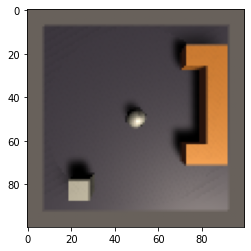

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

for index, shape in enumerate(spec.observation_shapes):
    print("index is: ",index,"\n")
    print("shape is: ",shape,"\n")
    if len(shape) == 3:
        print("Here is the first visual observation")
        plt.imshow(decision_steps.obs[index][0,:,:,:])
        plt.imsave("soccerworld.png",decision_steps.obs[index][0,:,:,:])
        plt.show()

for index, shape in enumerate(spec.observation_shapes):
      if len(shape) == 1:
        print("First vector observations : ", decision_steps.obs[index][0,:])

In [19]:
print(type(decision_steps.obs[0]),"\n\n\n")
print(decision_steps.obs[0])

import torch
ObsTensor=torch.tensor(decision_steps.obs[0])
print(ObsTensor,"\n\n\n")
print(ObsTensor.shape)

<class 'numpy.ndarray'> 



[[[[0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   ...
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]]

  [[0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   ...
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]]

  [[0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   ...
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]]

  ...

  [[0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   ...
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]
   [0.40784314 0.38039216 0.35686275]]

  [[0.40784314 0.

In [32]:
a = torch.arange(4.)
print("a is: ",a,"\n\n\n")
print("a shape is ", a.shape,"\n\n\n")

b=torch.reshape(a, (2, 2))
print("b is: ",b,"\n\n\n\n")
print("b shape is ", b.shape,"\n\n\n")


c = torch.tensor([[0, 1], [2, 3]])
print(c.shape)
d=torch.reshape(c, (-1,))
print("d is: ",d,"\n\n\n\n")
print("d shape is ", d.shape,"\n\n\n")

e = torch.tensor([[0, 1], [2, 3]])
print(e.reshape(-1,4))
e.reshape(-1,4).shape

a is:  tensor([0., 1., 2., 3.]) 



a shape is  torch.Size([4]) 



b is:  tensor([[0., 1.],
        [2., 3.]]) 




b shape is  torch.Size([2, 2]) 



torch.Size([2, 2])
d is:  tensor([0, 1, 2, 3]) 




d shape is  torch.Size([4]) 



tensor([[0, 1, 2, 3]])


torch.Size([1, 4])

In [35]:
m = torch.nn.Linear(20, 30)
input = torch.randn(128, 20)
print("input is: ",input,"\n\n\n")
print("input size: ",input.shape,"\n\n\n")
output = m(input)
print(output.size())

input is:  tensor([[-1.4874,  0.2152,  0.7147,  ..., -1.3536,  0.6347, -1.1290],
        [ 0.3162,  0.0486,  0.4353,  ...,  1.0005, -0.9771, -0.2368],
        [-0.1142, -0.9981,  0.1690,  ..., -0.9983, -0.8695,  0.6106],
        ...,
        [ 1.0717,  1.1052,  0.8028,  ...,  0.7956,  0.5646, -0.0835],
        [-1.1733, -1.7265,  0.9487,  ..., -0.0591, -2.3865, -1.5086],
        [-2.1969,  0.6667,  0.5122,  ...,  1.0265,  1.3482, -0.9558]]) 



input size:  torch.Size([128, 20]) 



torch.Size([128, 30])


## Writing a sub routine for unity movement - for discrete env

In [34]:
def subRoutine():
    episodes=list(range(2))
    Rewards=[]
    for episode in episodes:
        iterationRewards=[]
        for iteration in range(10):
            env.reset()
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            tracked_agent = -1 # -1 indicates not yet tracking
            done = False # For the tracked_agent
            episode_rewards = 0 # For the tracked_agent
            while not done:
            # Track the first agent we see if not tracking 
            # Note : len(decision_steps) = [number of agents that requested a decision]
                if tracked_agent == -1 and len(decision_steps) >= 1:
                      tracked_agent = decision_steps.agent_id[0] 

                # Generate an action for all agents
                actions_values = (
                qnet(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
                  )
              # Add some noise with epsilon to the values
                actions_values += 0.1 * (
                np.random.randn(actions_values.shape[0], actions_values.shape[1])
                ).astype(np.float32)
                # Pick the best action using argmax
                actions = np.argmax(actions_values, axis=1)
                actions.resize((len(decision_steps), 1))

                # Set the actions
                env.set_actions(behavior_name, actions)

                # Move the simulation forward
                env.step()

                # Get the new simulation results
                decision_steps, terminal_steps = env.get_steps(behavior_name)
                if tracked_agent in decision_steps: # The agent requested a decision
                      episode_rewards += decision_steps[tracked_agent].reward
                if tracked_agent in terminal_steps: # The agent terminated its episode
                      episode_rewards += terminal_steps[tracked_agent].reward
                      done = True
            iterationRewards.append(episode_rewards)
    #     Rewards.append((np.sum(iterationRewards))/10)
    #     print(iterationRewards)
    #     print(sum(iterationRewards))
        Rewards.append(sum(iterationRewards)/10)
        print(f"Total rewards for episode {episode} is {Rewards[episode]}")
    return episodes, Rewards

## (before using trained model)

In [69]:
qnet = VisualQNetwork((64, 84, 3), 126, 5)

In [70]:
episodes, Rewards=subRoutine()

Total rewards for episode 0 is -0.11499999519437551
Total rewards for episode 1 is 0.4550000077113509


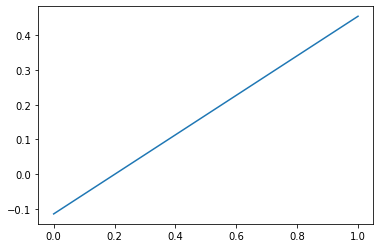

In [71]:
plt.plot(episodes, Rewards)

## (after using trained model)
## Load model

In [72]:
# Specify a path
PATH = "soccerWorld.pt"

# Load
qnet = torch.load(PATH)
qnet.eval()

VisualQNetwork(
  (conv1): Conv2d(3, 16, kernel_size=[8, 8], stride=[4, 4])
  (conv2): Conv2d(16, 32, kernel_size=[4, 4], stride=[2, 2])
  (dense1): Linear(in_features=1728, out_features=126, bias=True)
  (dense2): Linear(in_features=126, out_features=5, bias=True)
)

In [73]:
episodes, Rewards=subRoutine()

Total rewards for episode 0 is 0.9220000017434359
Total rewards for episode 1 is 0.8220000039786101


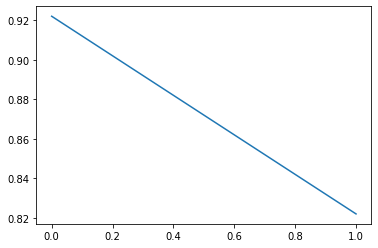

In [74]:
plt.plot(episodes, Rewards)

## Writing a sub routine for unity movement - for continous env

In [4]:
def subRoutineSoccer():
    episodes=list(range(20))
    Rewards=[]
    for episode in episodes:
        env.reset()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        tracked_agent = -1 # -1 indicates not yet tracking
        done = False # For the tracked_agent
        episode_rewards = 0 # For the tracked_agent
        while not done:
        # Track the first agent we see if not tracking 
        # Note : len(decision_steps) = [number of agents that requested a decision]
            if tracked_agent == -1 and len(decision_steps) >= 1:
                  tracked_agent = decision_steps.agent_id[0] 

            # Generate an action for all agents
            actions_values = (
            qnet(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
              )
            actions_values += 0.1 * (
            np.random.randn(actions_values.shape[0], actions_values.shape[1])
            ).astype(np.float32)
 
            actions_values.resize((len(decision_steps), 2))
# Store the action that was picked, it will be put in the trajectory later

# Set the actions in the environment
            env.set_actions(behavior_name, actions_values)

# Move the simulation forward
            env.step()
            # Get the new simulation results
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            if tracked_agent in decision_steps: # The agent requested a decision
                  episode_rewards += decision_steps[tracked_agent].reward
            if tracked_agent in terminal_steps: # The agent terminated its episode
                  episode_rewards += terminal_steps[tracked_agent].reward
                  done = True
        Rewards.append(episode_rewards)
    #     Rewards.append((np.sum(iterationRewards))/10)
    #     print(iterationRewards)
    #     print(sum(iterationRewards))
        print(f"Total rewards for episode {episode} is {Rewards[episode]}")
    return episodes, Rewards

## with Trained model

In [2]:
import torch

In [3]:
# Specify a path
PATH = "TrainedOnServer/soccerWorld.pt"

# Load
qnet = torch.load(PATH)
qnet.eval()

AttributeError: Can't get attribute 'VisualQNetwork' on <module '__main__'>

In [19]:
import numpy as np

Total rewards for episode 0 is -1.0
Total rewards for episode 1 is -0.5
Total rewards for episode 2 is -1.0
Total rewards for episode 3 is 3.0
Total rewards for episode 4 is 0.0
Total rewards for episode 5 is -1.0
Total rewards for episode 6 is 2.5
Total rewards for episode 7 is -1.0
Total rewards for episode 8 is -1.0
Total rewards for episode 9 is 3.0
Total rewards for episode 10 is 0.0
Total rewards for episode 11 is 3.0
Total rewards for episode 12 is 0.0
Total rewards for episode 13 is -1.0
Total rewards for episode 14 is -1.0
Total rewards for episode 15 is 0.0
Total rewards for episode 16 is 3.0
Total rewards for episode 17 is -1.0
Total rewards for episode 18 is 0.0
Total rewards for episode 19 is 3.0


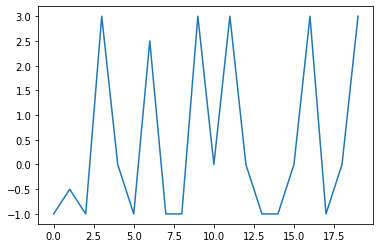

In [20]:
episodes, Rewards=subRoutineSoccer()
plt.plot(episodes, Rewards)

In [16]:
np.mean(Rewards)

1.175

In [24]:
env.close()

## without Trained model

In [21]:
qnet = VisualQNetwork((100, 100, 3), 126, 2)

Total rewards for episode 0 is 0.0
Total rewards for episode 1 is -1.0
Total rewards for episode 2 is 3.0
Total rewards for episode 3 is 0.0
Total rewards for episode 4 is -0.5
Total rewards for episode 5 is 0.0
Total rewards for episode 6 is -1.0
Total rewards for episode 7 is -0.5
Total rewards for episode 8 is 0.0
Total rewards for episode 9 is 0.0
Total rewards for episode 10 is 0.0
Total rewards for episode 11 is 3.0
Total rewards for episode 12 is -0.5
Total rewards for episode 13 is 0.0
Total rewards for episode 14 is -0.5
Total rewards for episode 15 is 0.0
Total rewards for episode 16 is 3.0
Total rewards for episode 17 is -1.0
Total rewards for episode 18 is 3.0
Total rewards for episode 19 is -1.0


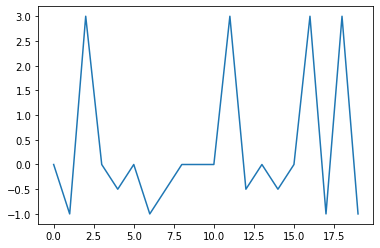

In [22]:
episodes, Rewards=subRoutineSoccer()
plt.plot(episodes, Rewards)

In [24]:
np.mean(Rewards)

-0.075

## Below are examples of decision steps and terminal steps

In [58]:
decision_steps.obs

[array([[[[0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          ...,
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434]],
 
         [[0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          ...,
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434]],
 
         [[0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          ...,
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434]],
 
         ...,
 
         [[0.5372549 , 0.54509807, 0.56078434],
          [0.53725

In [59]:
decision_steps.reward

array([0.], dtype=float32)

In [60]:
decision_steps.agent_id

array([0], dtype=int32)

In [61]:
decision_steps.action_mask #If there is a wall, then that direction action is a masked one

[array([[False,  True, False,  True, False]])]

In [62]:
len(decision_steps)

1

In [63]:
terminal_steps.obs

[array([[[[0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          ...,
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434]],
 
         [[0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          ...,
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434]],
 
         [[0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          [0.5372549 , 0.54901963, 0.56078434],
          ...,
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434],
          [0.5372549 , 0.54509807, 0.56078434]],
 
         ...,
 
         [[0.5372549 , 0.54509807, 0.56078434],
          [0.53725

In [64]:
terminal_steps.reward

array([-1.], dtype=float32)

In [65]:
terminal_steps.agent_id

array([0], dtype=int32)

In [66]:
terminal_steps.interrupted

array([False])

## Self check with random actions

In [27]:
from mlagents_envs.environment import UnityEnvironment
env=UnityEnvironment(file_name="UnityBuilds/soccerWorld_Adv", seed =1, side_channels=[])

In [28]:
env.reset()

In [29]:
decision_steps, terminal_steps = env.get_steps(behavior_name)

In [35]:
for i in 
actions_values = (
    qnet(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
  )
 
actions_values.resize((len(decision_steps), 2))
# Store the action that was picked, it will be put in the trajectory later

# Set the actions in the environment
env.set_actions(behavior_name, actions_values)

# Move the simulation forward
env.step()

In [36]:

reward=0
for agent_id_terminated in terminal_steps:
    # Create its last experience (is last because the Agent terminated)
    reward+=terminal_steps[agent_id_terminated].reward
    print(reward)
for agent_id_decisions in decision_steps:
    # Create its last experience (is last because the Agent terminated)
    reward=decision_steps[agent_id_decisions].reward
    print(reward)
          

0.0


In [39]:
def subRoutineSoccer():
    episodes=list(range(4))
    Rewards=[]
    for episode in episodes:
        env.reset()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        tracked_agent = -1 # -1 indicates not yet tracking
        done = False # For the tracked_agent
        episode_rewards = 0 # For the tracked_agent
        while not done:
        # Track the first agent we see if not tracking 
        # Note : len(decision_steps) = [number of agents that requested a decision]
            if tracked_agent == -1 and len(decision_steps) >= 1:
                  tracked_agent = decision_steps.agent_id[0] 

            # Generate an action for all agents
            actions_values = (
            qnet(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
              )
            actions_values += 0.1 * (
            np.random.randn(actions_values.shape[0], actions_values.shape[1])
            ).astype(np.float32)
 
            actions_values.resize((len(decision_steps), 2))
# Store the action that was picked, it will be put in the trajectory later

# Set the actions in the environment
            env.set_actions(behavior_name, actions_values)

# Move the simulation forward
            env.step()
            # Get the new simulation results
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            if tracked_agent in decision_steps: # The agent requested a decision
                  episode_rewards += decision_steps[tracked_agent].reward
            if tracked_agent in terminal_steps: # The agent terminated its episode
                  episode_rewards += terminal_steps[tracked_agent].reward
                  done = True
            Rewards.append(episode_rewards)
    #     Rewards.append((np.sum(iterationRewards))/10)
    #     print(iterationRewards)
    #     print(sum(iterationRewards))
        print(f"Total rewards for episode {episode} is {Rewards[episode]}")
    return episodes, Rewards

In [40]:
episodes,rewards=subRoutineSoccer()

Total rewards for episode 0 is -0.009999999776482582
Total rewards for episode 1 is -0.019999999552965164
Total rewards for episode 2 is -0.029999999329447746
Total rewards for episode 3 is -0.03999999910593033


## Once training is done, move the NN to eval mode.

In [ ]:
qnet.eval()

# To save the file as a ONNX model

In [ ]:
import onnx

In [ ]:
input_names=["visual_obs"]
output_names=["hidden"]

In [ ]:
torch.onnx.export(
    qnet, dummy_input, "gridWorld.onnx", verbose=True, input_names=input_names, output_names=output_names
    )

In [ ]:
import onnx

# Load the ONNX model
model = onnx.load("gridWorld.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

## Save the trained Model
### Save the entire model

In [49]:
# # Specify a path
# PATH = "GridWorld.pt"

# # Save
# torch.save(qnet, PATH)

# # Load
# model = torch.load(PATH)
# model.eval()

# soccerWorld to Specify a path
PATH = "soccerWorld.pt"

# Save
torch.save(qnet, PATH)

# Load
model = torch.load(PATH)
model.eval()


VisualQNetwork(
  (conv1): Conv2d(3, 16, kernel_size=[8, 8], stride=[4, 4])
  (conv2): Conv2d(16, 32, kernel_size=[4, 4], stride=[2, 2])
  (dense1): Linear(in_features=3872, out_features=126, bias=True)
  (dense2): Linear(in_features=126, out_features=2, bias=True)
)

In [ ]:
#sample forward prop run!
model(torch.from_numpy(decision_steps.obs[0])).detach().numpy()

### Save and load the model via state_dict
#### Let’s save and load our model using just state_dict

In [ ]:
#Save and load the model via state_dict
# Specify a path
PATH = "gridWorldStateDict.pt"

# Save
torch.save(qnet.state_dict(), PATH)

# Load
model = VisualQNetwork((64, 84, 3), 126, 5)
model.load_state_dict(torch.load(PATH))
model.eval()

In [25]:
env.close()